# Задание 5

Немного усложним наш первоначальный запрос и отдельно посчитаем ежедневную выручку с заказов новых пользователей нашего сервиса. Посмотрим, какую долю она составляет в общей выручке с заказов всех пользователей — и новых, и старых.

Задание:

Для каждого дня в таблицах orders и user_actions рассчитайте следующие показатели:

1. Выручку, полученную в этот день.
2. Выручку с заказов новых пользователей, полученную в этот день.
3. Долю выручки с заказов новых пользователей в общей выручке, полученной за этот день.
4. Долю выручки с заказов остальных пользователей в общей выручке, полученной за этот день.
Колонки с показателями назовите соответственно revenue, new_users_revenue, new_users_revenue_share, old_users_revenue_share. Колонку с датами назовите date. 

Все показатели долей необходимо выразить в процентах. При их расчёте округляйте значения до двух знаков после запятой.

Результат должен быть отсортирован по возрастанию даты.

Поля в результирующей таблице:

date, revenue, new_users_revenue, new_users_revenue_share, old_users_revenue_share

```sql
with revenue_table AS (
  SELECT
    date,
    sum(price) AS revenue
  FROM
    (
      SELECT
        unnest_query.date,
        unnest_query.product_id,
        products.price AS price
      FROM
        (
          SELECT
            order_id,
            creation_time :: date AS date,
            unnest(product_ids) AS product_id
          FROM
            orders
        ) AS unnest_query
        JOIN products using (product_id)
      WHERE
        unnest_query.order_id NOT in (
          SELECT
            order_id
          FROM
            user_actions
          WHERE
            action = 'cancel_order'
        )
    ) AS subq
  GROUP BY
    1
),
new_revenue_table AS (
  SELECT
    date,
    sum(price) AS new_users_revenue
  FROM
    (
      SELECT
        unnest_query.date,
        unnest_query.product_id,
        products.price AS price
      FROM
        (
          SELECT
            order_id,
            creation_time :: date AS date,
            unnest(product_ids) AS product_id
          FROM
            orders
        ) AS unnest_query
        JOIN products using (product_id)
      WHERE
        unnest_query.order_id NOT in (
          SELECT
            order_id
          FROM
            user_actions
          WHERE
            action = 'cancel_order'
        )
        and unnest_query.order_id in (
          SELECT
            order_id
          FROM
            user_actions
          WHERE
            (time :: date, user_id) in (
              SELECT
                min(time :: date),
                user_id
              FROM
                user_actions
              GROUP BY
                user_id
            )
        )
    ) AS subq
  GROUP BY
    1
)
SELECT
  *,
  round(new_users_revenue :: decimal / revenue * 100, 2) AS new_users_revenue_share,
  round(
    100.0 - new_users_revenue :: decimal / revenue * 100,
    2
  ) AS old_users_revenue_share
FROM
  revenue_table
  JOIN new_revenue_table using (date)
ORDER BY
  1
```

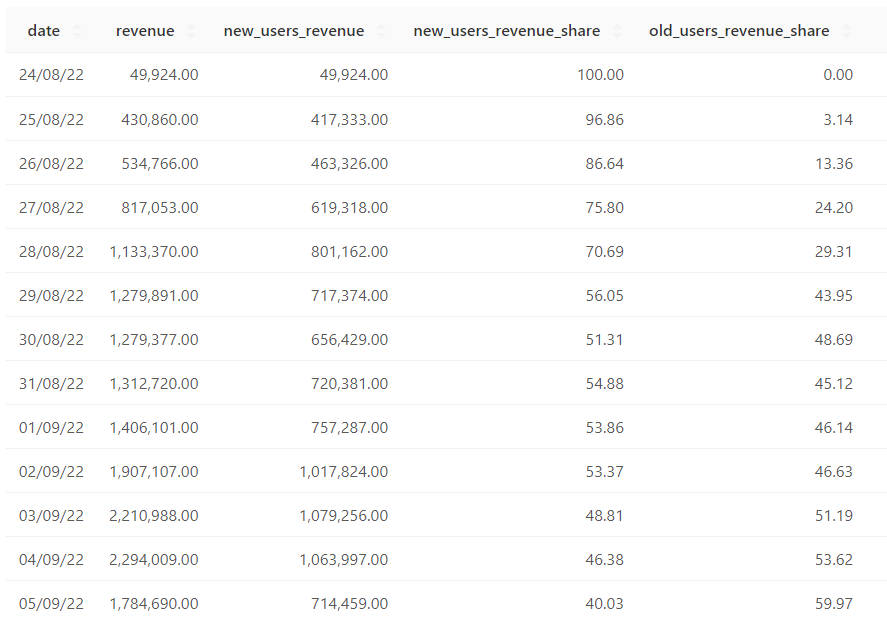

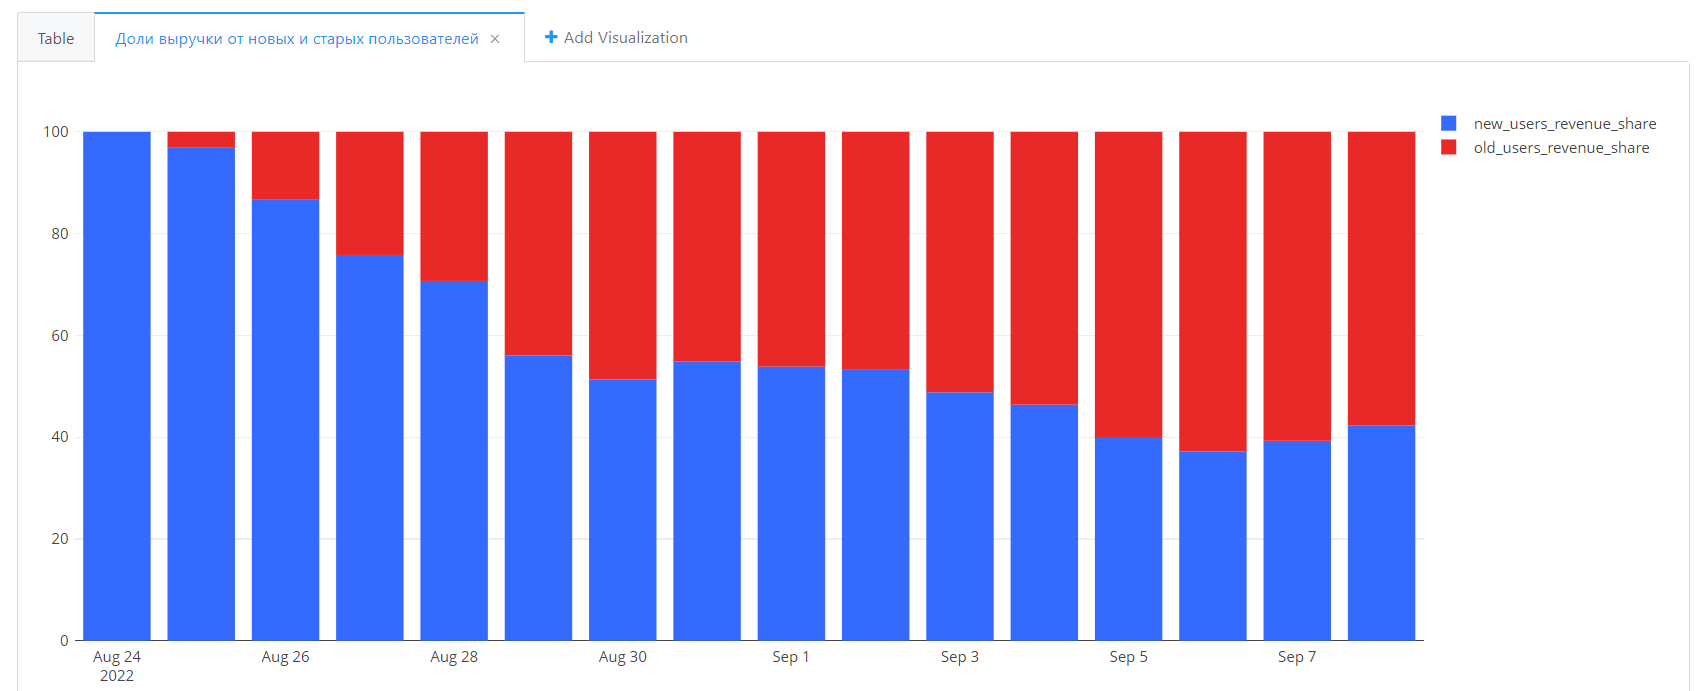